# *_Zurich: To Jazz or Not to Jazz_*

Finding the ideal spot to open bar jazz in Zurich, by Francisco Kim.

The aim of this project is thus to find potential areas in Zurich that would be ideal for a opening a jazz bar. A jazz bar can be a great place for promoting young talented musicians by giving them a location where they can produce their jazz gigs, and this can prove popular among the locals. The target audience is thus people who are interested in the bar/catering business who is looking to open one in Zurich.

For this, several criteria will be taken into account.

1. First of all, we will look for areas in Zurich that are *nice to hang out in*. Areas that contain other bars, restaurants etc. will be good candidate areas.
2. We will, however, not want to look at areas that are already overcrowded with bars in order to *avoid fierce competition*. In addition, we will look for other jazz bars in the region and avoid being near them.
3. We will also try to be not to far from the *Zurich University of the Arts* (Zürcher Hochschule der Künste or ZHdK), where jazz musicians are educated and formed. This will make it easier for them to come and play in our jazz bar.
4. Last but not least, we will try to find areas where the rent is *not too expensive*.

 The districts (or neighbourhood depending on the translation) in Zurich are numbered and called *Kreise* (e.g., Kreis 4) and there are 12 Kreise in Zurich. We will further segment the districts into circular areas with a radius of *800 metres* so that we can look at smaller candidate areas.



# Loding modules

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

# Import Modules
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from geopy import distance
from geopy.exc import GeocoderTimedOut
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import time, sys
from shapely.geometry import shape, Point, Polygon
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Define functions
def extract_loc(address, trials = 0):
    time.sleep(10)
    limit = 8
    try:
        return geolocator.geocode(address, geometry='geojson')
    except GeocoderTimedOut:
        if trials <= limit:
            trials += 1
            return extract_loc(address, trials)
        elif trials > limit:
            return None
        
def extract_ad(coordinates, trials = 0):
    time.sleep(10)
    limit = 8
    try:
        return geolocator.reverse("{}, {}".format(coordinates[0], coordinates[1])).address
    except GeocoderTimedOut:
        if trials <= limit:
            trials += 1
            return extract_ad(coordinates, trials)
        elif trials > limit:
            return None


# Explore Dataset of Zurich

Get coordinates of Zurich city



In [ ]:
geolocator = Nominatim(user_agent="zurich_boundaries")

district_name = []
districts = {}

zurich = extract_loc('Zurich city')
if zurich != None:
    city = zurich.raw['geojson']
    LAT = zurich.latitude
    LON = zurich.longitude
else: print('Timeout error')

# Saving just in case
#with open('../data/zurich.json', 'w') as outfile:
#    json.dump(city, outfile)
    
# print("{}, {}".format(LAT, LON))

In [3]:
city

{'type': 'Polygon',
 'coordinates': [[[8.4480061, 47.3802489],
   [8.4484713, 47.3796659],
   [8.4491004, 47.3792406],
   [8.4497709, 47.3788071],
   [8.450468, 47.3783562],
   [8.4511626, 47.3781669],
   [8.4517686, 47.3781319],
   [8.45256, 47.378139],
   [8.4533881, 47.3781466],
   [8.4542052, 47.3781003],
   [8.4552295, 47.3781025],
   [8.4563798, 47.3780073],
   [8.4574042, 47.3777761],
   [8.457809, 47.3777187],
   [8.4586318, 47.3777109],
   [8.4592677, 47.3776378],
   [8.4599477, 47.3775009],
   [8.4605952, 47.3772084],
   [8.4613644, 47.3768124],
   [8.4621053, 47.3764308],
   [8.4628786, 47.3760325],
   [8.4639203, 47.3754474],
   [8.4641815, 47.3752694],
   [8.4644728, 47.3750708],
   [8.4645996, 47.3749844],
   [8.4654386, 47.3744359],
   [8.466191, 47.37412],
   [8.4669045, 47.3738201],
   [8.4676081, 47.3735734],
   [8.4681295, 47.3737372],
   [8.4686834, 47.3738244],
   [8.4693986, 47.3738835],
   [8.470189, 47.3739492],
   [8.4702245, 47.3739521],
   [8.4703413, 47.3735

Show Zurich city

In [5]:
zurich_map = folium.Map(location=[LAT, LON], zoom_start=12)

folium.Choropleth(geo_data=city,
                      xfill_color='YlOrRd', 
                      key_on='display_name',
                      fill_opacity=0.7, 
                      line_opacity=0.2).add_to(zurich_map)

# Show map
zurich_map

To divide city in to a circular patches (or grid) of 11 x 11, we get a rectangle that fits the city

In [6]:
poly = Polygon(city['coordinates'][0])
# Get (minx, miny, maxx, maxy) of the polygon
poly.bounds

(8.4480061, 47.3202203, 8.6254413, 47.4346662)

We now calculate the center points of each circle area, which will then be used for drawing circles of radius 800 m.

In [7]:
nb_division = 11
x_div = np.linspace(poly.bounds[0], poly.bounds[2], nb_division+1)
y_div = np.linspace(poly.bounds[1], poly.bounds[3], nb_division+1)

# Get middle point of each segments
x = list((x_div[1:] + x_div[:-1]) / 2)
y = list((y_div[1:] + y_div[:-1]) / 2)

# Obtain center of circles covering Zurich
ccenters = [(i,j) for i in x for j in y]

Get data on district boundaries



In [ ]:
geolocator = Nominatim(user_agent="zurich_boundaries")

district_name = []
districts = {}

for i in range(0,12):
    district_name.append('Kreis {}'.format(str(i+1)))
    #location = geolocator.geocode('{}, Zurich'.format(district_name[i]), geometry='geojson')
    location = extract_loc('{}, Zurich'.format(district_name[i]))
    districts[district_name[i]] = location.raw['geojson']  
    time.sleep(10)

# Kreis 4 info is wrong; rectify this
location = extract_loc('Aussersihl, Zurich')
districts[district_name[3]] = location.raw['geojson']  
    
# Keep data locally to avoid using timeout-error-prone geopy
with open('../data/zurich_districts.json', 'w') as outfile:
    json.dump(districts, outfile)

In [9]:
# Load (saved) district boudary data
with open('../data/zurich_districts.json') as json_file:
    districts = json.load(json_file)

Make list out of district boundaries



In [10]:
district_boundaries = []

for i in range(0,12):
    district_boundaries.append(districts['Kreis {}'.format(str(i+1))])  #+END_SRC

Map of Kreis 4 to show that we have the wanted data


In [11]:
district_map = folium.Map(location=[LAT, LON], zoom_start=12)
folium.Choropleth(geo_data=districts['Kreis 4'],
                      xfill_color='YlOrRd', 
                      key_on='display_name',
                      fill_opacity=0.7, 
                      line_opacity=0.2).add_to(district_map)
district_map

Create dataframe with the coordinates of the circle batches, and check whether coordinates are in one of the districts in Zurich:



In [12]:
# Define the dataframe columns
column_names = ['Latitude', 'Longitude', 'Neighbourhood'] 

# Instantiate the dataframe
grid = pd.DataFrame(columns=column_names)

# Check whether points are in one of the Kreise. 
for k in range(len(ccenters)):
    for i,j in enumerate(district_boundaries):
        polygon = Polygon(j['coordinates'][0])
        if polygon.contains(Point(ccenters[k])):
            grid = grid.append({'Latitude': ccenters[k][1], 'Longitude': ccenters[k][0], 'Neighbourhood': i}, ignore_index=True)

grid['Neighbourhood'] = grid['Neighbourhood'].astype(int)

grid.head(3)

,Latitude,Longitude,Neighbourhood
0,47.367039,8.472202,8
1,47.377443,8.472202,8
2,47.387847,8.472202,8


Show our circular areas covering Zurich city:



In [13]:
kreisgrid_map = folium.Map(location=[LAT, LON], zoom_start=11)

# Define colours for the circles in map
colour = cm.rainbow(np.linspace(0, 1, 12))
rainbow = [colors.rgb2hex(i) for i in colour]

# 
for lat, lon, nei, ind in zip(grid['Latitude'], grid['Longitude'], grid['Neighbourhood'], grid.index):
    folium.Circle(
	    [lat, lon],
        radius=800,
        popup=folium.Popup('Kreis ' + str(nei) + ', grid ' + str(ind), parse_html=True),
        color=rainbow[nei-1],
        fill=True,
        fill_color=rainbow[nei-1],
        fill_opacity=0.7).add_to(kreisgrid_map)
    
# Show map
kreisgrid_map

Drop grid 44 that is on the lake


In [14]:
grid = grid.drop([44]).reset_index(drop=True)

Save grid dataframe locally to csv:



In [ ]:
grid.to_csv('../data/grid.csv')

Load (saved) grid dataframe locally to csv:



In [15]:
grid = pd.read_csv('../data/grid.csv', index_col=0)

We have divided Zurich in 67 areas in total:

In [16]:
grid.shape

(67, 3)


# Unsupervised clustering (k-means)

Import Foursquare credentials:



In [17]:
with open('../data/foursquare_credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['username']
    CLIENT_SECRET = data['password']

Define function to get nearby-venues, and get them:

In [18]:
# library to handle requests
import requests

# Foursquare API version
#VERSION = '20180605'
VERSION = '20191229'
# limit of number of venues returned by Foursquare API
LIMIT = 100
RADIUS = 800

# defining function to retrieve nearby venues
def getNearbyVenues(names, kreisnb, latitudes, longitudes, radius=RADIUS):
    
    venues_list=[]
    perc = 0
    
    for name, kreis, lat, lng in zip(names, kreisnb, latitudes, longitudes):
        # Progress bar
        perc += 1
        progress = "{} / {} done".format(perc, len(names))
        sys.stdout.write("\r" + progress)
        sys.stdout.flush()
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            kreis,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Grid',
                  'Neighbourhood',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Obtain venues



In [ ]:
venuesdf = getNearbyVenues(names=grid.index,
                                   kreisnb=grid['Neighbourhood'],
                                   latitudes=grid['Latitude'],
                                   longitudes=grid['Longitude']
                                  )

Save data locally (just in case):



In [ ]:
venuesdf.to_csv('../data/venuesdf.csv')

In [31]:
venuesdf = pd.read_csv('../data/venuesdf.csv', index_col=0)
venuesdf.head()

,Grid,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,8,47.367039,8.472202,SZU Uitikon Waldegg,47.366052,8.465721,Light Rail Station
1,0,8,47.367039,8.472202,pro Garage GmbH,47.368689,8.463705,Auto Garage
2,0,8,47.367039,8.472202,Baroth,47.368614,8.463147,Café
3,0,8,47.367039,8.472202,Restaurant Waldegg,47.367676,8.462106,Beer Garden
4,1,8,47.377443,8.472202,Sportanlage Buchlern,47.380655,8.477250,Soccer Field


One-hot encoding before clustering



In [32]:
# one hot encoding
onehot = pd.get_dummies(venuesdf[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe and move it to the first column
onehot['Grid'] = venuesdf['Grid'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(3)

,Grid,Accessories Store,American Restaurant,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Bathing Area,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Car Wash,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Hill,Historic Site,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Trade School,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Group rows by grid number and by taking the mean of the frequency of occurrence of each category:



In [33]:
groupeddf = onehot.groupby('Grid').mean().reset_index()
groupeddf.head()

,Grid,Accessories Store,American Restaurant,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Bathing Area,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Car Wash,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Hill,Historic Site,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Trade School,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Write first a function to sort the venues in descending order:



In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
# Choose top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Grid']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

# create a new dataframe
grid_venues_sorted = pd.DataFrame(columns=columns)
grid_venues_sorted['Grid'] = groupeddf['Grid']

for ind in np.arange(groupeddf.shape[0]):
    grid_venues_sorted.iloc[ind, 1:] = return_most_common_venues(groupeddf.iloc[ind, :], num_top_venues)

grid_venues_sorted

,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,0,Café,Beer Garden,Auto Garage,Light Rail Station,Zoo Exhibit,Exhibit,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop
1,1,Bus Station,Soccer Field,Scenic Lookout,Zoo Exhibit,Electronics Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm
2,2,Pool,Thai Restaurant,Restaurant,Dance Studio,Bus Stop,Bus Station,Spanish Restaurant,Supermarket,Convenience Store,Hill
3,3,Tram Station,Convenience Store,Thai Restaurant,Soccer Field,Bus Stop,Hawaiian Restaurant,Miscellaneous Shop,Restaurant,Skate Park,Train Station
4,4,Outdoor Sculpture,Trail,Swiss Restaurant,Light Rail Station,Tea Room,Scenic Lookout,Electronics Store,Event Space,Exhibit,Zoo Exhibit
5,5,Bus Station,Hotel,Supermarket,Breakfast Spot,Light Rail Station,Pizza Place,Thai Restaurant,Convenience Store,Scenic Lookout,Molecular Gastronomy Restaurant
6,6,Bus Station,Restaurant,Swiss Restaurant,Grocery Store,Gym,Middle Eastern Restaurant,Café,Scenic Lookout,Stadium,Supermarket
7,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place
8,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa
9,9,Bus Station,Tram Station,Bakery,Indian Restaurant,Spa,Food & Drink Shop,Italian Restaurant,Grocery Store,Zoo Exhibit,Falafel Restaurant


Number by category



In [36]:
groupeddf = onehot.groupby('Grid').sum().reset_index()
groupeddf.head()

,Grid,Accessories Store,American Restaurant,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Bathing Area,Beach,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cable Car,Cafeteria,Café,Campground,Candy Store,Car Wash,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Hill,Historic Site,History Museum,Hobby Shop,Hockey Rink,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Laser Tag,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Rental Car Location,Restaurant,River,Rock Club,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Trade School,Trail,Train Station,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Get 10 most common venues for each grid



In [37]:
# Choose top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Grid']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

# create a new dataframe
grid_venues_sorted = pd.DataFrame(columns=columns)
grid_venues_sorted['Grid'] = groupeddf['Grid']

for ind in np.arange(groupeddf.shape[0]):
    grid_venues_sorted.iloc[ind, 1:] = return_most_common_venues(groupeddf.iloc[ind, :], num_top_venues)

grid_venues_sorted

,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,0,Café,Beer Garden,Auto Garage,Light Rail Station,Zoo Exhibit,Exhibit,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop
1,1,Bus Station,Soccer Field,Scenic Lookout,Zoo Exhibit,Electronics Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm
2,2,Pool,Thai Restaurant,Restaurant,Dance Studio,Bus Stop,Bus Station,Spanish Restaurant,Supermarket,Convenience Store,Hill
3,3,Tram Station,Convenience Store,Thai Restaurant,Soccer Field,Bus Stop,Hawaiian Restaurant,Miscellaneous Shop,Restaurant,Skate Park,Train Station
4,4,Outdoor Sculpture,Trail,Swiss Restaurant,Light Rail Station,Tea Room,Scenic Lookout,Electronics Store,Event Space,Exhibit,Zoo Exhibit
5,5,Bus Station,Hotel,Supermarket,Breakfast Spot,Light Rail Station,Pizza Place,Thai Restaurant,Convenience Store,Scenic Lookout,Molecular Gastronomy Restaurant
6,6,Bus Station,Restaurant,Swiss Restaurant,Grocery Store,Gym,Middle Eastern Restaurant,Café,Scenic Lookout,Stadium,Supermarket
7,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place
8,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa
9,9,Bus Station,Tram Station,Bakery,Indian Restaurant,Spa,Food & Drink Shop,Italian Restaurant,Grocery Store,Zoo Exhibit,Falafel Restaurant


Find inflection point



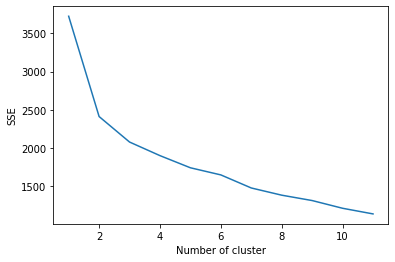

In [38]:
groupeddf_clustering = groupeddf.drop('Grid', 1)

sse = {}
for kclusters in range(1, 12):
    kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(groupeddf_clustering)
    data["clusters"] = kmeans.labels_
    sse[kclusters] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

k-means to cluster the neighborhood into 3 clusters.



In [28]:
# set number of clusters
kclusters = 3

groupeddf_clustering = groupeddf.drop('Grid', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(groupeddf_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

Create new dataframe that includes the cluster as well as the top 10 venues for each grid:



In [29]:
# add clustering labels
grid_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# Merge coordinates and neighbourhood data as well
clusterdf = pd.concat([grid_venues_sorted, grid], axis=1, sort=False)

clusterdf

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood
0,1,0,Café,Beer Garden,Auto Garage,Light Rail Station,Zoo Exhibit,Exhibit,Food & Drink Shop,Food,Fondue Restaurant,Flower Shop,47.367039,8.472202,8
1,1,1,Bus Station,Soccer Field,Scenic Lookout,Zoo Exhibit,Electronics Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,47.377443,8.472202,8
2,1,2,Pool,Thai Restaurant,Restaurant,Dance Studio,Bus Stop,Bus Station,Spanish Restaurant,Supermarket,Convenience Store,Hill,47.387847,8.472202,8
3,1,3,Tram Station,Convenience Store,Thai Restaurant,Soccer Field,Bus Stop,Hawaiian Restaurant,Miscellaneous Shop,Restaurant,Skate Park,Train Station,47.398252,8.472202,8
4,1,4,Outdoor Sculpture,Trail,Swiss Restaurant,Light Rail Station,Tea Room,Scenic Lookout,Electronics Store,Event Space,Exhibit,Zoo Exhibit,47.356635,8.488332,2
5,1,5,Bus Station,Hotel,Supermarket,Breakfast Spot,Light Rail Station,Pizza Place,Thai Restaurant,Convenience Store,Scenic Lookout,Molecular Gastronomy Restaurant,47.367039,8.488332,8
6,1,6,Bus Station,Restaurant,Swiss Restaurant,Grocery Store,Gym,Middle Eastern Restaurant,Café,Scenic Lookout,Stadium,Supermarket,47.377443,8.488332,8
7,0,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place,47.387847,8.488332,8
8,0,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa,47.398252,8.488332,8
9,1,9,Bus Station,Tram Station,Bakery,Indian Restaurant,Spa,Food & Drink Shop,Italian Restaurant,Grocery Store,Zoo Exhibit,Falafel Restaurant,47.408656,8.488332,9


Cluster map



In [30]:
cluster_map = folium.Map(location=[LAT, LON], zoom_start=12)

# Define colours for the circles in map
colour = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colour]

# 
for lat, lon, cluster, ind in zip(clusterdf['Latitude'], clusterdf['Longitude'], clusterdf['Cluster Labels'], clusterdf.index):
    folium.Circle(
	    [lat, lon],
        radius=800,
        popup=folium.Popup('Cluster ' + str(cluster) + ', grid ' + str(ind), parse_html=True),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cluster_map)
    
# Show map
cluster_map

Choose the cluster predominantly occupied by bars:

After inspection of each of the clusters, we see that the clusters 1 and 3 are the areas predominantly occupied by bars and restaurants, i.e., hang-out places, where as the cluster 2 predominantly has bus stations and convenience stores etc. We thus choose this cluster to work with.



In [47]:
cluster3df = clusterdf.loc[(clusterdf['Cluster Labels'] != 1)]
cluster3df.head(3)

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood
7,0,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place,47.387847,8.488332,8
8,0,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa,47.398252,8.488332,8
16,0,16,Bus Station,Hotel,Supermarket,Light Rail Station,Tram Station,Plaza,Thai Restaurant,Lounge,Molecular Gastronomy Restaurant,Falafel Restaurant,47.367039,8.504463,2



# Analysing & using more data


## Import rent price per Kreis

Get the information from the Zurich city webpage.



In [ ]:
!wget -O /home/francis/Dropbox/commands/ibm/9-applied-data-science-capstone/project/mietpreise.csv https://www.stadt-zuerich.ch/content/dam/stzh/prd/Deutsch/Statistik/Themen/Bauen-Wohnen/Nettomietpreise_nach-Kreis-Wohnungsgroesse-Eigentumsgruppe.xlsx

As the file is small, copy-paste the part directly from the csv file of the spreadsheet number 3 that is of our interest, and then import:



In [48]:
# Load the file after working manually the csv file with libreoffice
#    as the data file is small
rentdf = pd.read_csv('../data/mietpreise.csv', names=['Neighbourhood', 'CHF'])
rentdf

,Neighbourhood,CHF
0,Ganze Stadt,22.5
1,Kreis 1,29.0
2,Kreis 2,22.8
3,Kreis 3,23.3
4,Kreis 4,23.4
5,Kreis 5,24.2
6,Kreis 6,23.6
7,Kreis 7,23.0
8,Kreis 8,25.0
9,Kreis 9,21.6


In [49]:
rentdf.drop(0, inplace=True)
rentdf["Neighbourhood"] = rentdf["Neighbourhood"].str.split(" ", expand = True).drop(0, axis=1).astype(int)
rentdf

,Neighbourhood,CHF
1,1,29.0
2,2,22.8
3,3,23.3
4,4,23.4
5,5,24.2
6,6,23.6
7,7,23.0
8,8,25.0
9,9,21.6
10,10,22.2


In [50]:
rentsorteddf = rentdf.sort_values(by='CHF', ascending=True, axis=0)
rentsorteddf

,Neighbourhood,CHF
12,12,20.7
11,11,21.1
9,9,21.6
10,10,22.2
2,2,22.8
7,7,23.0
3,3,23.3
4,4,23.4
6,6,23.6
5,5,24.2


In [51]:
rentsorteddf.drop("CHF", axis = 1, inplace=True)
rentsorteddf['Expensiveness'] = range(1,13)
rentsorteddf

,Neighbourhood,Expensiveness
12,12,1
11,11,2
9,9,3
10,10,4
2,2,5
7,7,6
3,3,7
4,4,8
6,6,9
5,5,10


Merge the rent info to our dataframe:



In [52]:
cl3df = pd.merge(cluster3df, rentsorteddf, how='left', on='Neighbourhood')
cl3df[['Neighbourhood', 'Expensiveness']].tail(10)

,Neighbourhood,Expensiveness
14,10,4
15,7,6
16,6,9
17,6,9
18,5,10
19,10,4
20,10,4
21,10,4
22,6,9
23,6,9



# Calculate distance to the Zürcher Hochschule der Künste (ZHdK)

Obtain ZHdK coordinates that we would like to have close by:



In [55]:
ZHdK_add = 'Pfingstweidstrasse 96, 8005 Zürich'
location = extract_loc(ZHdK_add, trials = 0)
zhdk = [location.latitude, location.longitude]

Obtain coordinates of music venues (also close by if possible):



In [56]:
musicvenuesdf = venuesdf[venuesdf['Venue Category'].str.contains('Music')]
musicvenuesdf.reset_index(drop=True, inplace=True)
musicvenuesdf

,Grid,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,18,3,47.387847,8.504463,Komplex 457,47.387495,8.499809,Music Venue
1,18,3,47.387847,8.504463,Gleis71,47.391681,8.510140,Music Venue
2,27,2,47.367039,8.520593,Bundeshaus zu Wiedikon,47.373589,8.519774,Music Venue
3,28,3,47.377443,8.520593,Bundeshaus zu Wiedikon,47.373589,8.519774,Music Venue
4,28,3,47.377443,8.520593,"Volkshaus, Theatersaal",47.375484,8.527428,Music Venue
5,35,1,47.346231,8.536724,Rote Fabrik,47.343607,8.536923,Music Venue
6,54,6,47.377443,8.568985,Live @ Sunset,47.375166,8.576677,Music Venue
7,60,6,47.377443,8.585115,Live @ Sunset,47.375166,8.576677,Music Venue


In [57]:
music_coord = []
music_label = []

# Coordinates & name of music venues
for i in range(musicvenuesdf.shape[0]):
    music_coord.append([musicvenuesdf.loc[i, 'Venue Latitude'], musicvenuesdf.loc[i, 'Venue Longitude']])
    music_label.append(musicvenuesdf.loc[i, 'Venue'])

Obtain coordinates of the jazz bar that we would like to have far away:



In [58]:
jazzclub = venuesdf[venuesdf['Venue Category'].str.contains('Jazz')]
jazzclub.reset_index(drop=True, inplace=True)
jazzclub

,Grid,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,29,4,47.387847,8.520593,Moods,47.388769,8.518725,Jazz Club



# Filtering 1: less than 5 bars

1.  Count number of bars per grid area:



In [59]:
newonehot = onehot[['Grid', 'Bar']].groupby('Grid', as_index=False).sum()
newonehot.head(3)

,Grid,Bar
0,0,0
1,1,0
2,2,0


Merge this dataframe with our main dataframe:



In [60]:
barfreqdf = pd.merge(cl3df, newonehot, how='left', on='Grid')
barfreqdf.head(3)

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood,Expensiveness,Bar
0,0,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place,47.387847,8.488332,8,11,0
1,0,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa,47.398252,8.488332,8,11,0
2,0,16,Bus Station,Hotel,Supermarket,Light Rail Station,Tram Station,Plaza,Thai Restaurant,Lounge,Molecular Gastronomy Restaurant,Falafel Restaurant,47.367039,8.504463,2,5,0


Choose grid areas with less than 5 bars



In [61]:
bar5df = barfreqdf[barfreqdf['Bar'] < 5]

Show grid areas of cluster 3 with less than 5 bars



In [62]:
bar_map = folium.Map(location=[LAT, LON], zoom_start=12)

# Define colours (cheap -> blue; expensive -> red)
colour = cm.RdBu_r(np.linspace(0, 1, 12))
redblue = [colors.rgb2hex(i) for i in colour]
# 
for lat, lon, nei, price, grid in zip(bar5df['Latitude'], bar5df['Longitude'],
                                      bar5df['Neighbourhood'], bar5df['Expensiveness'], bar5df['Grid']):
    folium.Circle(
        [lat, lon],
        radius=800,
        popup=folium.Popup('Grid ' + str(grid) + ', Kreis ' + str(nei) + ', Price: ' + str(price), parse_html=True),
        color=redblue[price-1],
        fill=True,
        fill_color=redblue[price-1],
        fill_opacity=0.7).add_to(bar_map)
    
for coord, name in zip(music_coord, music_label):
    folium.Circle(
        coord,
        radius=20,
        popup=folium.Popup(str(name), parse_html=True),
        color='green').add_to(bar_map)

folium.Circle(
    [jazzclub.loc[0, 'Venue Latitude'], jazzclub.loc[0, 'Venue Longitude']],
    radius=20,
    popup=folium.Popup('Existing Jazz club'),
    color='red'
    ).add_to(bar_map)

folium.Circle(
    zhdk,
    radius=20,
    popup=folium.Popup('Zurich University of the Arts'),
    color='blue'
    ).add_to(bar_map)
    
# Show map
bar_map

# Filtering 2 : close to the ZHdK

We see that only 2 of the music venues are of our interest, so choose only those two:


In [63]:
music_label

['Komplex 457',
 'Gleis71',
 'Bundeshaus zu Wiedikon',
 'Bundeshaus zu Wiedikon',
 'Volkshaus, Theatersaal',
 'Rote Fabrik',
 'Live @ Sunset',
 'Live @ Sunset']

In [64]:
musiclabel = music_label[:2]
musiccoord = music_coord[:2]

Calculate the distance between the grid area centers and the ZHdK:



In [65]:
dist_list = []

# Calculate distance from the Zurich University of the Arts
for i in range(barfreqdf.shape[0]):
    dist_list.append(distance.distance(zhdk, [barfreqdf.loc[i, 'Latitude'], barfreqdf.loc[i, 'Longitude']]).km)
    
barfreqdf['Distance'] = dist_list

barfreqdf.head(3)

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood,Expensiveness,Bar,Distance
0,0,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place,47.387847,8.488332,8,11,0,1.795092
1,0,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa,47.398252,8.488332,8,11,0,1.966048
2,0,16,Bus Station,Hotel,Supermarket,Light Rail Station,Tram Station,Plaza,Thai Restaurant,Lounge,Molecular Gastronomy Restaurant,Falafel Restaurant,47.367039,8.504463,2,5,0,2.671257


Choose grid areas that are less than 2 km from the music university:



In [66]:
bardf = barfreqdf[(barfreqdf['Bar'] < 5) & (barfreqdf['Distance'] < 2)]
bardf.head(3)

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood,Expensiveness,Bar,Distance
0,0,7,Restaurant,Supermarket,Hotel,Tram Station,Bakery,Swiss Restaurant,Gym,Fast Food Restaurant,Middle Eastern Restaurant,Salad Place,47.387847,8.488332,8,11,0,1.795092
1,0,8,Bakery,Tram Station,Bus Station,Gym,Supermarket,Bistro,Plaza,Mexican Restaurant,Beach,Spa,47.398252,8.488332,8,11,0,1.966048
3,0,17,Italian Restaurant,Hotel,Café,Gym / Fitness Center,Swiss Restaurant,Bar,Bakery,Supermarket,Stadium,Tram Station,47.377443,8.504463,2,5,2,1.557941


Show map of grid areas with less than 5 bars and less than 2 km from the music university:



In [67]:
price_map = folium.Map(location=[LAT*1.0004, LON*0.995], zoom_start=13.3)

# Define colours (cheap -> blue; expensive -> red)
colour = cm.RdBu_r(np.linspace(0, 1, 12))
redblue = [colors.rgb2hex(i) for i in colour]
# 
for lat, lon, nei, price, grid in zip(bardf['Latitude'],
                                      bardf['Longitude'], bardf['Neighbourhood'],
                                      bardf['Expensiveness'], bardf['Grid']):
    folium.Circle(
	    [lat, lon],
        radius=800,
        popup=folium.Popup('Grid ' + str(grid) + ', Kreis ' + str(nei) + ', Price: ' + str(price), parse_html=True),
        color=redblue[price-1],
        fill=True,
        fill_color=redblue[price-1],
        fill_opacity=0.7).add_to(price_map)
    
for coord, name in zip(musiccoord, musiclabel):
    folium.Circle(
	    coord,
        radius=20,
        popup=folium.Popup(str(name), parse_html=True),
        color='green').add_to(price_map)

folium.Circle(
    [jazzclub.loc[0, 'Venue Latitude'], jazzclub.loc[0, 'Venue Longitude']],
    radius=20,
    popup=folium.Popup('Existing Jazz club'),
    color='red'
    ).add_to(price_map)

folium.Circle(
    zhdk,
    radius=20,
    popup=folium.Popup('Zurich University of the Arts'),
    color='blue'
    ).add_to(price_map)
    
# Show map
price_map


# Filtering 3: mean rent price per Kreis



In [68]:
candidatedf = bardf[bardf['Expensiveness'] <= 7]
candidatedf

,Cluster Labels,Grid,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue,Latitude,Longitude,Neighbourhood,Expensiveness,Bar,Distance
3,0,17,Italian Restaurant,Hotel,Café,Gym / Fitness Center,Swiss Restaurant,Bar,Bakery,Supermarket,Stadium,Tram Station,47.377443,8.504463,2,5,2,1.557941
4,0,18,Hotel,Swiss Restaurant,Restaurant,Italian Restaurant,Pizza Place,Bar,Café,Hotel Bar,Supermarket,Plaza,47.387847,8.504463,3,7,2,0.628275
5,0,19,Tram Station,Plaza,Swiss Restaurant,Pizza Place,Café,Bus Station,Grocery Store,Rental Car Location,Discount Store,Chinese Restaurant,47.398252,8.504463,9,3,0,1.018958



# Results

Show map



In [69]:
candidate_map = folium.Map(location=[LAT*1.0004, LON*0.995], zoom_start=13.3)

# Define colours (cheap -> blue; expensive -> red)
colour = cm.RdBu_r(np.linspace(0, 1, 12))
redblue = [colors.rgb2hex(i) for i in colour]
# 
for lat, lon, nei, price, grid in zip(candidatedf['Latitude'],
                                     candidatedf['Longitude'], candidatedf['Neighbourhood'],
                                     candidatedf['Expensiveness'], bardf['Grid']):
    folium.Circle(
	    [lat, lon],
        radius=800,
        popup=folium.Popup('Grid ' + str(grid) + ', Kreis ' + str(nei) + ', Price: ' + str(price), parse_html=True),
        color=redblue[price-1],
        fill=True,
        fill_color=redblue[price-1],
        fill_opacity=0.7).add_to(candidate_map)
    
for coord, name in zip(musiccoord, musiclabel):
    folium.Circle(
	    coord,
        radius=20,
        popup=folium.Popup(str(name), parse_html=True),
        color='green').add_to(candidate_map)

folium.Circle(
    [jazzclub.loc[0, 'Venue Latitude'], jazzclub.loc[0, 'Venue Longitude']],
    radius=20,
    popup=folium.Popup('Existing Jazz club'),
    color='red'
    ).add_to(candidate_map)

folium.Circle(
    zhdk,
    radius=20,
    popup=folium.Popup('Zurich University of the Arts'),
    color='blue'
    ).add_to(candidate_map)
    
# Show map
candidate_map

Extract address of the center of the candidate grids:



In [ ]:
address_list = []
geolocator = Nominatim(user_agent="zurich_address")
perc = 0

candidatedf = candidatedf.reset_index(drop=True)

for i in range(candidatedf.shape[0]):
    try:
        location = extract_ad([candidatedf["Latitude"][i], candidatedf["Longitude"][i]])
        address_list.append(location)
    except:
        address_list.append("{}, failed".format(i))
        print("\n{}, failed".format(i))
    
    # Progress bar
    perc += 1
    progress = "{} / {} done".format(perc, candidatedf.shape[0])
    sys.stdout.write("\r" + progress)
    sys.stdout.flush()

    time.sleep(10)

When geopy works, we get the following addresses:

0: Albisriederstrasse, Sihlfeld, Wiedikon, Zurich, 8003 Switzerland

1: Hohlstrasse, Hard, Aussersihl, Zurich, 8048 Switzerland

2: Ackersteinstrasse, Höngg, Zurich, 8049 Switzerland

Show coordinates of the candidate grids



In [76]:
candidatedf[['Latitude', 'Longitude']]

,Latitude,Longitude
0,47.377443,8.504463
1,47.387847,8.504463
2,47.398252,8.504463
